# **Pediatric Age**

In [50]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import Image

In [37]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)
#df = pd.read_csv('data/clinic_sympt.csv')
data_clean = pd.read_csv('/Users/pablopazosdominguez/Desktop/bitsxlamarato2020/data/clinic_sympt.csv')
df = pd.read_csv('/Users/pablopazosdominguez/Desktop/bitsxlamarato2020/data/clinic_sympt.csv')

In [16]:
def plot_roc(model, X_test, y_test):
    probabilities = model.predict_proba(np.array(X_test))
    predictions = probabilities[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions, pos_label='no_covid')
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



## Data cleaning and feature selection



In [17]:
data_clean = df.drop([
    'participant_id',
    'id',
    'recruit_date',
    'postal_code',
    'province',
    'family_country',
    'row_school',
    'bus',
    'sports_type',
    'm2',
    'rooms',
    'floor_level',
    'persons_home',
    'survey_type',
    'housemember_symptoms___1',
    'housemember_symptoms___2',
    'housemember_symptoms___3',
    'housemember_symptoms___4',
    'housemember_symptoms___5',
    'school_symptoms_member___1',
    'school_symptoms_member___2',
    'school_symptoms_member___4',
    'school_symptoms_member___5',
    'simptomatology_date',
    'cxr_date',
    'thoracic_ct_date',
    'survey_end_date',
    'pcr_date',
    'antigenic_date',
    'final_diagnosis_text',  # it can be referenced by final_diagnosis_code
    'comments',
    'ag_test_mark',
    'name_initials_of_the_inter',
    'pcr_result',
    'antigenic_result',
    'pcr_type',
    'pcr_performed',
    'antigenic_performed',
    'antigenic_sample',
    'final_outcome',
    'final_outcome_complete',
    'comorbidities_complete',
    'coviral_binary',
    'final_classification_of_th',
    'inclusion_criteria',
    'sex',
    'sports',
    'sero'
], axis=1)



*   Recoding categorical variables




In [18]:
two_categorical_cols = ['smokers_home', 'fever', 'ausc_resp', 'wheezing',
                        'crackles', 'cxr2', 'ct2']

data_clean[two_categorical_cols] = data_clean[two_categorical_cols] - 1
data_clean['final_diagnosis_code'] = data_clean['final_diagnosis_code'].apply(
    lambda x: 'covid' if x <= 2 else 'no_covid')

*   Fever time = *diff(date_fevers)*

In [19]:
dt = pd.to_datetime(data_clean.date_fever, format='%Y-%m-%d')
dt1 = pd.to_datetime(data_clean.end_fever, format='%Y-%m-%d')
data_clean['fever_time'] = (dt1 - dt).dt.days
data_clean = data_clean.drop([
    'total_days_fever',
    'date_fever',
    'end_fever'], axis=1)

* Feature selection by setting a threshold of 90% missing data in a variable.

In [20]:
def rmissingvaluecol(dff, threshold):
    l = []
    l = list(dff.drop(dff.loc[:, list((100 * (dff.isnull().sum() / len(dff.index)) >= threshold))].columns,
                      1).columns.values)
    return l

In [21]:
l = rmissingvaluecol(data_clean, 90)
data_clean = data_clean[l]

In [22]:
def replace_vals(x):
    pattern = "^([0-9]+)"
    matches = re.findall(pattern, str(x))
    if len(matches) > 0:
        return float(matches[0])
    else:
        return np.nan

In [23]:
data_clean['sat_hb_o2_value'] = data_clean['sat_hb_o2_value'].apply(lambda x: replace_vals(x))

+ One hot encoding format for the training

In [24]:
one_hot_encoding_columns = []
for i in data_clean.columns:
    if data_clean[i].dtype in (int, float):
        if 1 < data_clean[i].max() <= 9:
            data_clean[i].astype('category')
            one_hot_encoding_columns.append(i)

data_clean_dum = pd.get_dummies(data_clean,
                                columns=one_hot_encoding_columns)  # one hot encoding of all categorical variables
data_clean = data_clean_dum.fillna(0)
data_clean = data_clean.replace(np.nan, 0)

## Modeling data

In [25]:
data = data_clean.drop(['final_diagnosis_code'], axis=1)
label = data_clean['final_diagnosis_code']
model = RandomForestClassifier(n_estimators=5, random_state=42)
train_features, test_features, train_labels, test_labels = train_test_split(data, label, test_size=0.25,
                                                                            random_state=42, stratify=label)

Model pipeline

+  We use Random Undersampling because the lack of postive cases in our dataset. It is not the best case scenario but in terms of data understanding we thing it is a good resource

In [26]:
steps = [('under', RandomUnderSampler()), ('model', RandomForestClassifier(max_depth=3))]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, data, label, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.785


In [27]:
pipeline.fit(train_features, train_labels)

importance = pipeline['model'].feature_importances_
for i in train_features.columns:
    if train_features.columns.get_loc(i) == importance.argmax():
        print(train_features[i].name)

predictions = pipeline.predict(test_features)

home_confirmed


In [28]:
tn, fp, fn, tp = metrics.confusion_matrix(test_labels, predictions).ravel()
print("Percentage of COVID cases correctly diagnosed:", round((tn*100/(tn+fn)),3))
print("Percentage of COVID cases not diagnosis:", round((fn*100/(tn+fn)),3))
print("\nPercetange of NOT-COVID cases correctly diagnosed:", round((tp*100/(tp+fp)),3))
print("Percetange of NOT-COVID cases not correctly diagnosed:", round((fp*100/(tp+fp)),3))

Percentage of COVID cases correctly diagnosed: 45.977
Percentage of COVID cases not diagnosis: 54.023

Percetange of NOT-COVID cases correctly diagnosed: 93.114
Percetange of NOT-COVID cases not correctly diagnosed: 6.886


<AxesSubplot:>

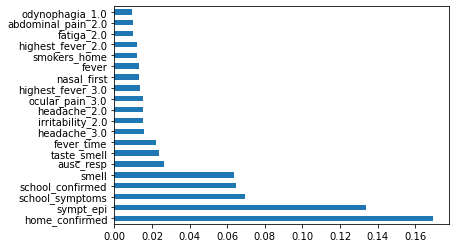

In [29]:
feat_importances = pd.Series(importance, index=test_features.columns)
feat_importances.nlargest(20).plot(kind='barh')

In this Plot, we see that the features with more importance are ambiental once. 

Consequently, we try to analyze without those ambiental symptoms to focus on symptomatolofical context.

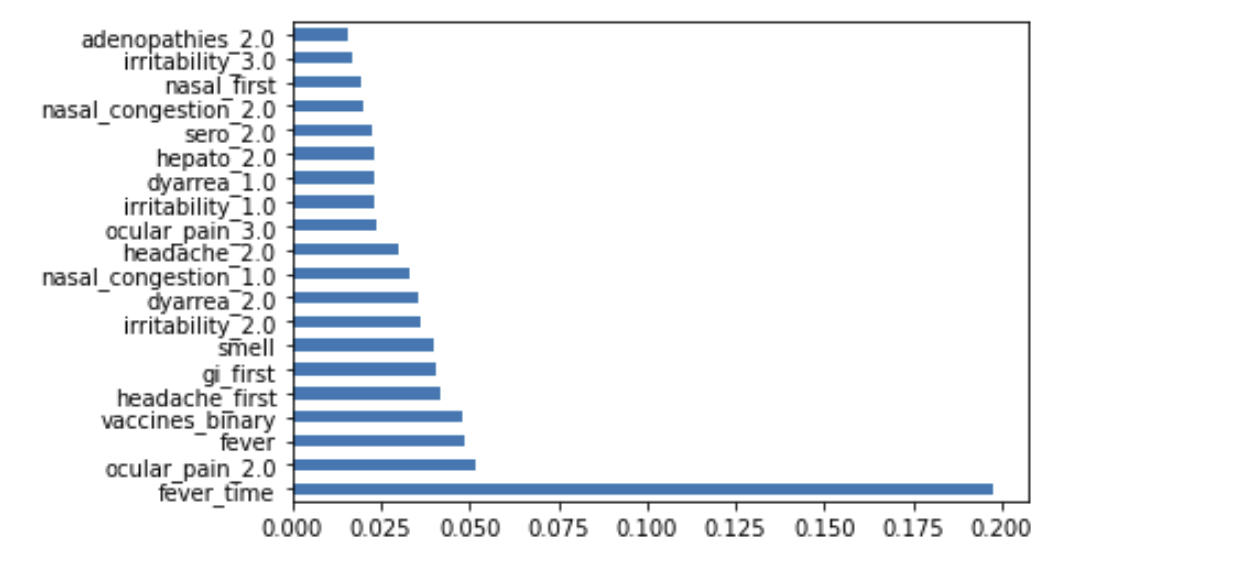

In [52]:
Image(filename = "/Users/pablopazosdominguez/Desktop/symptoms_analyze.png", width = 600, height = 300)

We can see in this plot that the symptoms that are most relevant.

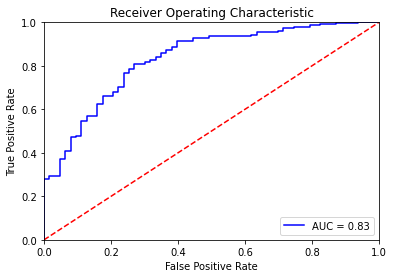

In [30]:
plot_roc(pipeline['model'], test_features, test_labels)

## Explainability

In order to improve the explainability, we made a logistic regression to select the features with more significance in the dataset. Assuming a lack in its predictive power, we have done a Decision tree instead of Random Forest to illustrate important paths. For example:
*  Not Home confirmed, no school symptoms, no sympt_epi, no inflammation, smell consevance and no fever gives us 944 cases of the Dataset.
* Home confirmed, ausc_resp, school  symptoms, no fever, no symptoms we have 46 COVID-19 cases.

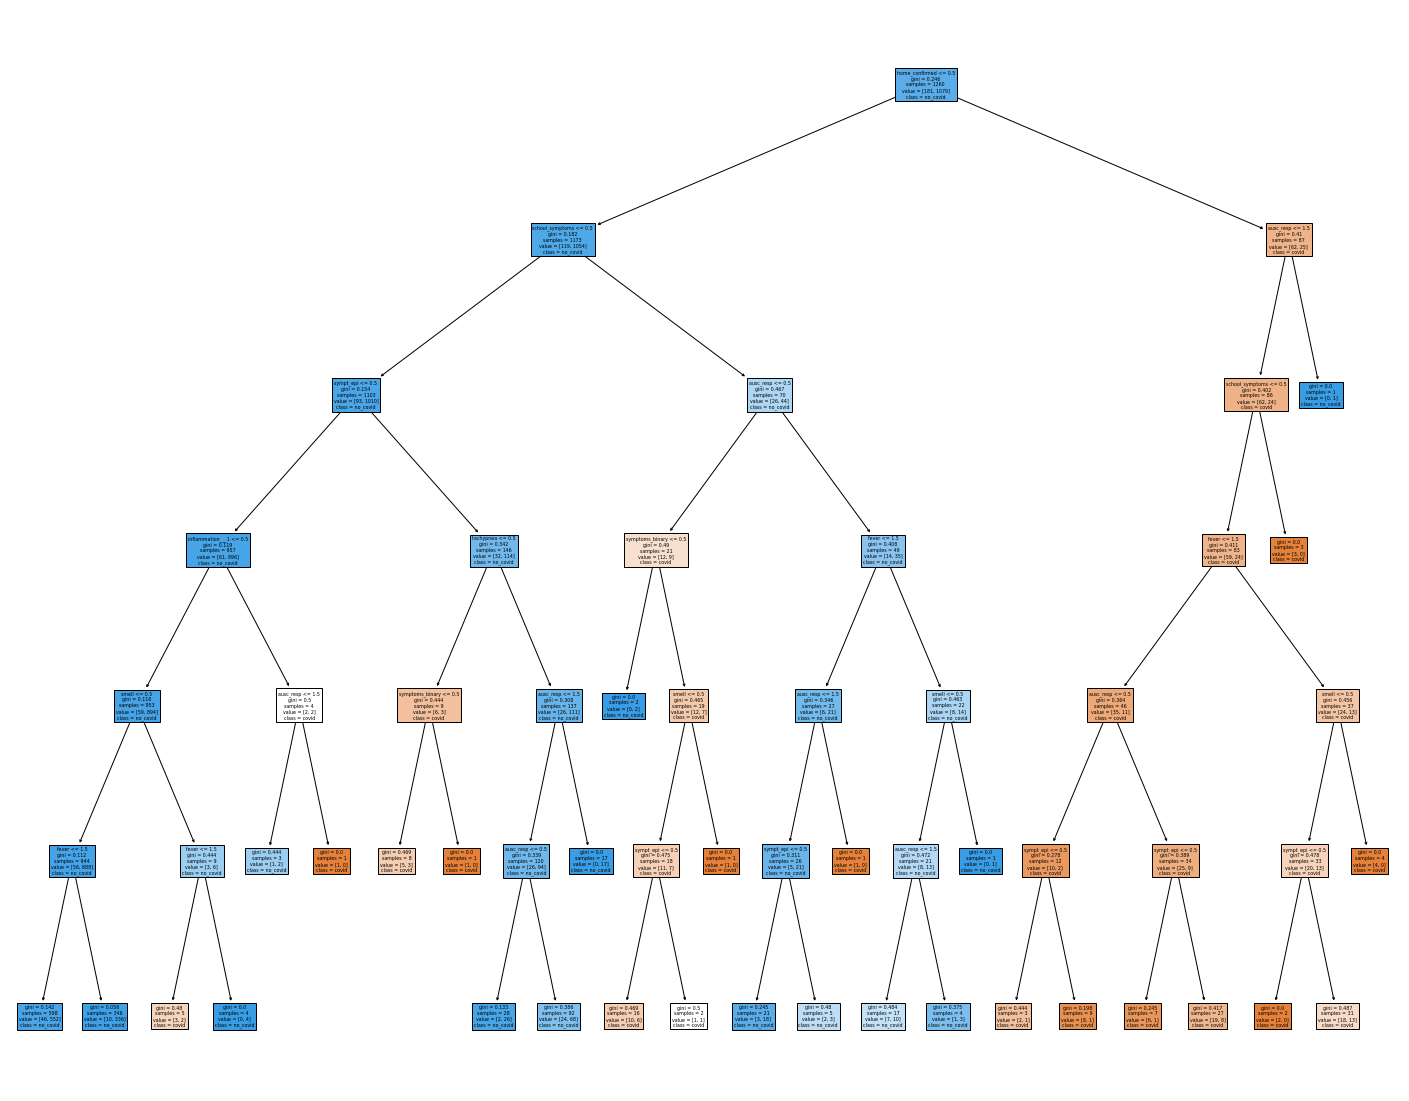

In [43]:
data_done = df[['sympt_epi','home_confirmed','school_symptoms',
                        'symptoms_binary','fever','tachypnea','ausc_resp','smell','inflammation___1','final_diagnosis_code']].copy() #pillamos solo los datos de Martí

data_done['final_diagnosis_code'] = data_done['final_diagnosis_code'].apply(lambda x: 'covid' if x <= 2 else 'no_covid') 

labels = data_done['final_diagnosis_code']
features = data_done.drop(['final_diagnosis_code'],axis=1)
features = features.fillna(0) #todos los NA a 0, porque sí

from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

clf2 = DecisionTreeClassifier(max_depth = 6, random_state=1234)
model = clf2.fit(train_features, train_labels)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf2, feature_names=train_features.columns, class_names=['covid','no_covid'], filled=True)

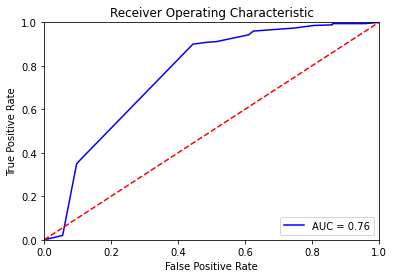

In [44]:
plot_roc(clf2,test_features,test_labels)

In [45]:
predictions = clf2.predict(test_features)
tn, fp, fn, tp = metrics.confusion_matrix(test_labels, predictions).ravel()
print("Percentage of COVID cases correctly diagnosed:", round((tn*100/(tn+fn)),3))
print("Percentage of COVID cases not diagnosis:", round((fn*100/(tn+fn)),3))
print("\nPercetange of NOT-COVID cases correctly diagnosed:", round((tp*100/(tp+fp)),3))
print("Percetange of NOT-COVID cases not correctly diagnosed:", round((fp*100/(tp+fp)),3))

Percentage of COVID cases correctly diagnosed: 65.854
Percentage of COVID cases not diagnosis: 34.146

Percetange of NOT-COVID cases correctly diagnosed: 88.158
Percetange of NOT-COVID cases not correctly diagnosed: 11.842


We have studied the variables and those that did not have direct disclosure with COVID have been discarded. From there, statistical analyzes have been carried out to see results are the variables that most explain the model.

Two models have been developed. One with a RandomForest that has a better prediction, especially ruling out cases that we know do NOT have COVID. And a second model with a regression tree that sacrifices some precision metrics in the position that it is more understandable for a doctor, nurse ... someone outside the computing environment.